#### Background
As smart phone penetration reaches the hundreds of millions mark, O2O (Online to Offline) requires businesses to have a strong presence both offline and online. APPs with O2O capabilities accumulate daily consumer behaviour and location data that require big data and commercial operations management. The competition at hand focuses on coupon redemption rates. Sending coupons is a general O2O marketing tool used to activate existing customers and attract new ones. While customers are happy to receive coupons that they want, they are frustrated when receiving coupons that they do not need. For merchants, sending unwanted coupons may erode brand equity and hinder marketing expense forecasting. Targeted marketing is an important technology to increase the coupon redemption rate, providing relevant discounts to customers and effective marketing tools to businesses. The competition provides participants with abundant O2O data in this field and expects contestants to predict whether the customer will use the coupon within a specified time frame.
### Data
This competition provides real online and offline user consumption data from January 1, 2016 to June 30, 2016. The contestants are expected to predict the probability of customers redeeming a coupon within 15 days of receiving it.
Note: To protect the privacy of users and merchants, data is desensitized and under biased sampling.
### Evaluation
The results are evaluated based on the average AUC value. That is, the AUC value is calculated for every coupon_id. The average of each AUC value is the evaluation score. More information on AUC value calculation method on wikipedia.


In [120]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
df_test=  pd.read_csv('ccf_offline_stage1_test_revised.csv')
print(df_test.shape)
df_test.head(20)

(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708
5,4005121,450,9983,30:5,0.0,20160706
6,4347394,450,9983,30:5,0.0,20160716
7,3094273,760,13602,30:5,1.0,20160727
8,5139970,450,9983,30:5,10.0,20160729
9,3237121,760,13602,30:5,1.0,20160703


In [122]:
df_test.isna().sum()

User_id              0
Merchant_id          0
Coupon_id            0
Discount_rate        0
Distance         12064
Date_received        0
dtype: int64

In [123]:
coupon_ids_test = df_test[(df_test["Coupon_id"].isna()==False)]
coupons_test = np.array(coupon_ids_test["Coupon_id"].astype(int))
coupons_test

array([ 9983,  3429,  6928, ...,  7590, 13602,   613])

### Training Offline Data

In [124]:
df_of = pd.read_csv('ccf_offline_stage1_train.csv')
print(df_of.shape)
df_of.head(20)

(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0
7,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
8,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
9,2029232,450,1532.0,30:5,0.0,20160530.0,NaN


In [125]:
df_of.isna().sum()

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

In [126]:
#User_ids and its frequency
df_of['User_id'].value_counts().head()

5054119    264
2751537    155
2949273    137
6655171    136
4840568    134
Name: User_id, dtype: int64

In [127]:
df_of.Coupon_id.describe()

count    1.053282e+06
mean     6.815398e+03
std      4.174276e+03
min      1.000000e+00
25%      2.840000e+03
50%      7.430000e+03
75%      1.032300e+04
max      1.404500e+04
Name: Coupon_id, dtype: float64

In [128]:
df_of.Coupon_id.nunique()

9738

In [129]:
coupon_ids_of = df_of[(df_of["Coupon_id"].isna()==False)]
coupons_of = coupon_ids_of["Coupon_id"].astype(int).unique()
min(coupons_of)

1

In [130]:
#number of unique coupons for test and offline training data
len(set(coupons_of).intersection(set(coupons_test)))

1118

In [131]:
# coupon_ids_on = df_on[(df_on["Coupon_id"].isna()==False) & (df_on["Coupon_id"]!='fixed')]
# coupons_on = coupon_ids_on["Coupon_id"].astype(int).unique()
# len(set(coupons_on).intersection(set(coupons_test)))

In [132]:
df_of.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date'],
      dtype='object')

In [133]:
#Removing duplicates and giving frequency counts to each row
x = 'g8h.|$hTdo+jC9^@'    
df_of_unique = (df_of.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_of_unique

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
0,4,1433,8735.0,30:5,10.0,20160214.0,NaN,1
1,4,1469,2902.0,0.95,10.0,20160607.0,NaN,1
2,35,3381,1807.0,300:30,0.0,20160130.0,NaN,1
3,35,3381,9776.0,10:5,0.0,20160129.0,NaN,1
4,35,3381,11951.0,200:20,0.0,20160129.0,NaN,1
...,...,...,...,...,...,...,...,...
1716986,7360967,3103,NaN,NaN,2.0,NaN,20160120.0,1
1716987,7360967,6485,10323.0,20:5,1.0,20160322.0,NaN,2
1716988,7361024,1433,8735.0,30:5,10.0,20160211.0,NaN,1
1716989,7361032,2146,11173.0,100:10,2.0,20160129.0,NaN,1


In [134]:
df_of_unique['Date'] = pd.to_datetime(df_of_unique["Date"],format='%Y%m%d')
df_of_unique['Date_received'] = pd.to_datetime(df_of_unique["Date_received"],format='%Y%m%d')
df_of_unique.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
0,4,1433,8735.0,30:5,10.0,2016-02-14,NaT,1
1,4,1469,2902.0,0.95,10.0,2016-06-07,NaT,1
2,35,3381,1807.0,300:30,0.0,2016-01-30,NaT,1
3,35,3381,9776.0,10:5,0.0,2016-01-29,NaT,1
4,35,3381,11951.0,200:20,0.0,2016-01-29,NaT,1


In [135]:
df_of[(df_of['Distance'].isna()) & (df_of['Date'].isna())]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
13,2747744,6901,1097.0,50:10,NaN,20160606.0,NaN
17,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
24,343660,4663,11002.0,150:20,NaN,20160528.0,NaN
52,106443,450,3732.0,30:5,NaN,20160429.0,NaN
58,2621792,4433,190.0,200:20,NaN,20160131.0,NaN
...,...,...,...,...,...,...,...
1754771,2346848,7555,17.0,30:5,NaN,20160204.0,NaN
1754772,2346848,6284,7379.0,50:10,NaN,20160204.0,NaN
1754844,457900,7907,13118.0,150:30,NaN,20160418.0,NaN
1754848,4056416,7177,3469.0,20:1,NaN,20160514.0,NaN


### Training Online Data

In [136]:
df_on = pd.read_csv('ccf_online_stage1_train.csv')
print(df_on.shape)
df_on_total = df_on.shape[0]
df_on.head(20)

(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0
5,14336199,18907,0,NaN,NaN,NaN,20160618.0
6,14336199,18907,0,NaN,NaN,NaN,20160618.0
7,14336199,18907,0,NaN,NaN,NaN,20160618.0
8,14336199,18907,0,NaN,NaN,NaN,20160618.0
9,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [137]:
df_on.isna().sum()

User_id                 0
Merchant_id             0
Action                  0
Coupon_id        10557469
Discount_rate    10557469
Date_received    10557469
Date               655898
dtype: int64

In [138]:
#Date==Null and Coupon_id==Null: no such cases
df_on[(df_on["Date"].isna()) & (df_on["Coupon_id"].isna())].shape

(0, 7)

In [139]:
#Date==Null and Coupon_id!=Null: Coupon not redeemed(5.73%) and customer only 'gets Coupon'
df_not_redeemed = df_on[(df_on["Date"].isna()) & (df_on["Coupon_id"].isna()==False)]
df_not_redeemed.shape

(655898, 7)

In [140]:
df_not_redeemed["Action"].describe()

count    655898.0
mean          2.0
std           0.0
min           2.0
25%           2.0
50%           2.0
75%           2.0
max           2.0
Name: Action, dtype: float64

In [141]:
#Date!=Null and Coupon_id==Null: No coupon(92.36%) and the customer only 'clicks' and 'buys'
df_no_coupon = df_on[(df_on["Date"].isna()==False) & (df_on["Coupon_id"].isna())]
df_no_coupon.shape

(10557469, 7)

In [142]:
df_no_coupon["Action"].unique()

array([1, 0])

In [143]:
#82.23% times customer only clicks
df_no_coupon[df_no_coupon["Action"]==0].shape

(9401780, 7)

In [144]:
#10.11% times customer buys with no coupon
df_no_coupon[df_no_coupon["Action"]==0].shape

(9401780, 7)

In [145]:
#coupon redeemed 1.89% times ('buys')
df_redeemed = df_on[(df_on["Date"].isna()==False) & (df_on["Coupon_id"].isna()==False)]
df_redeemed.shape

(216459, 7)

In [146]:
df_redeemed["Action"].unique()

array([1])

In [147]:
df_on.nunique(axis = 0) 

User_id          762858
Merchant_id        7999
Action                3
Coupon_id         27747
Discount_rate        64
Date_received       167
Date                182
dtype: int64

In [148]:
df_on.groupby(['User_id','Merchant_id']).head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0
...,...,...,...,...,...,...,...
11429821,13087731,27715,0,NaN,NaN,NaN,20160629.0
11429822,13087731,52005,0,NaN,NaN,NaN,20160324.0
11429823,13087731,45611,0,NaN,NaN,NaN,20160422.0
11429824,13683699,18009,1,NaN,NaN,NaN,20160323.0


In [149]:
#When coupon==fixed, coupon redeemed the same day
df_fix = df_on[df_on["Coupon_id"]=="fixed"]
df_fix.shape, df_fix[df_fix["Date_received"]==df_fix["Date"]].shape

((131546, 7), (131546, 7))

In [150]:
df_on.index.name="Index"

In [151]:
# df_on[(df_on["User_id"]==14336199)]

In [152]:
# df_on[(df_on["User_id"]==10998966) & (df_on["Merchant_id"]==14305)]

In [153]:
df_on.columns

Index(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date'],
      dtype='object')

In [154]:
df_on.drop_duplicates().shape

(5822543, 7)

In [155]:
#Removing duplicates and giving frequency counts to each row
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique.shape

(5822543, 8)

In [156]:
df_on_unique.Count.describe()

count    5.822543e+06
mean     1.963030e+00
std      3.430659e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.300000e+02
Name: Count, dtype: float64

In [157]:
arr = list(df_on_unique["Count"])
arr.sort(reverse=True)
arr[:10]

[630, 504, 444, 432, 378, 367, 336, 336, 333, 322]

In [158]:
df_on_unique.nunique()

User_id          762858
Merchant_id        7999
Action                3
Coupon_id         27747
Discount_rate        64
Date_received       167
Date                182
Count               233
dtype: int64

In [159]:
coupon_ids = df_on_unique[(df_on_unique["Coupon_id"].isna()==False) & (df_on_unique["Coupon_id"]!='fixed')]
coupons = coupon_ids["Coupon_id"].astype(int).unique()
max(coupons)

100233610

In [160]:
# df_on_unique[df_on_unique["User_id"]==10998966]

In [161]:
Actions = df_on_unique["Action"]

In [162]:
pd.get_dummies(df_on_unique['Action'])

,0,1,2
0,0,0,1
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
5822538,1,0,0
5822539,1,0,0
5822540,1,0,0
5822541,1,0,0


In [163]:
df_online_actions= pd.concat([df_on_unique,pd.get_dummies(df_on_unique['Action'], prefix='Action',dummy_na=False)],axis=1)


In [164]:
#Getting action values based on the count value
df_online_actions['Action_0'] = df_online_actions['Action_0'] * df_online_actions['Count']
df_online_actions['Action_1'] = df_online_actions['Action_1'] * df_online_actions['Count']
df_online_actions['Action_2'] = df_online_actions['Action_2'] * df_online_actions['Count']
# df_online_actions[df_online_actions['User_id']==10998966]
df_online_actions

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Action_0,Action_1,Action_2
0,4,25104,2,100145044,100:10,20160331.0,NaN,1,0,0,1
1,4,45612,1,NaN,NaN,NaN,20160308.0,1,0,1,0
2,36,46701,0,NaN,NaN,NaN,20160120.0,1,1,0,0
3,64,11200,0,NaN,NaN,NaN,20160526.0,1,1,0,0
4,64,29214,0,NaN,NaN,NaN,20160606.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5822538,15499999,55202,0,NaN,NaN,NaN,20160317.0,8,8,0,0
5822539,15499999,56502,0,NaN,NaN,NaN,20160227.0,1,1,0,0
5822540,15499999,59011,0,NaN,NaN,NaN,20160321.0,1,1,0,0
5822541,15499999,59512,0,NaN,NaN,NaN,20160116.0,1,1,0,0


In [165]:
# df_online_actions = df_online_actions.groupby('User_id')['Action_1','Action_0'].sum()
# df_online_actions['buy_clicks'] = df_online_actions['Action_1']/df_online_actions['Action_0']
# df_online_actions  = df_online_actions.replace([np.inf, -np.inf], -1)
# df_online_actions["buy_clicks"].value_counts()

In [166]:
# df_online_actions_ = pd.DataFrame(df_online_actions).reset_index()
# df_online_actions_[df_online_actions_["User_id"]==10998966]

In [167]:
df_on_unique['Date'] = pd.to_datetime(df_on_unique["Date"],format='%Y%m%d')
df_on_unique['Date_received'] = pd.to_datetime(df_on_unique["Date_received"],format='%Y%m%d')

In [168]:
df_on_unique[df_on_unique['Action']==2]
df_on_unique[(df_on_unique['Coupon_id']=='100032161') & (df_on_unique["Action"]==2)]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count


In [169]:
# df_on_unique.groupby(['User_id'])['Action'].apply(list)

In [170]:
df_on_unique

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
0,4,25104,2,100145044,100:10,2016-03-31,NaT,1
1,4,45612,1,NaN,NaN,NaT,2016-03-08,1
2,36,46701,0,NaN,NaN,NaT,2016-01-20,1
3,64,11200,0,NaN,NaN,NaT,2016-05-26,1
4,64,29214,0,NaN,NaN,NaT,2016-06-06,1
...,...,...,...,...,...,...,...,...
5822538,15499999,55202,0,NaN,NaN,NaT,2016-03-17,8
5822539,15499999,56502,0,NaN,NaN,NaT,2016-02-27,1
5822540,15499999,59011,0,NaN,NaN,NaT,2016-03-21,1
5822541,15499999,59512,0,NaN,NaN,NaT,2016-01-16,1


### Users involved in both online and offline transactions

In [171]:
on_off = df_on_unique.append(df_of_unique, sort=False)

In [172]:
on_off

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
2,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN
3,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN
4,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN
...,...,...,...,...,...,...,...,...,...
1716986,7360967,3103,NaN,NaN,NaN,NaT,2016-01-20,1,2.0
1716987,7360967,6485,NaN,10323,20:5,2016-03-22,NaT,2,1.0
1716988,7361024,1433,NaN,8735,30:5,2016-02-11,NaT,1,10.0
1716989,7361032,2146,NaN,11173,100:10,2016-01-29,NaT,1,2.0


In [173]:
#number of users having both online and offline presence
users_on_off = set(df_on_unique["User_id"].unique()).intersection(set(df_of_unique["User_id"]))
len(users_on_off)

267448

In [174]:
users_on = set(df_on["User_id"].unique())  #number of users in online data
users_of = set(df_of["User_id"].unique())  #number of users in offline data
users_test = set(df_test["User_id"].unique())
users_on_of = set(users_of.intersection(users_on))
len(users_on), len(users_of)

(762858, 539438)

In [175]:
len(users_test.intersection(users_on)), len(users_test.intersection(users_of))

(43155, 76307)

In [176]:
len((users_test.intersection(users_of)))

76307

In [177]:
#number of users using only online and only offline services
len(users_on - users_on_off), len(users_of - users_on_off)

(495410, 271990)

In [178]:
merch_on = set(df_on["Merchant_id"].unique())  #number of Merchant in online data
merch_of = set(df_of["Merchant_id"].unique())  #number of Merchants in offline data
merch_test = set(df_test["Merchant_id"].unique())

In [179]:
len(merch_test.intersection(merch_on)), len(merch_test.intersection(merch_of))

(0, 1558)

In [180]:
on_off = on_off[on_off['User_id'].isin(list(users_on_off))]
on_off.shape

(2168771, 9)

In [181]:
on_off[on_off["User_id"]==36]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
2,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN
6,36,1041,NaN,13490,30:5,2016-01-25,NaT,1,4.0
7,36,5717,NaN,12349,20:5,2016-01-25,NaT,1,8.0


In [182]:
on_off = on_off.sort_values(by=['User_id'])

In [183]:
on_off.reset_index(drop=True, inplace=True)
on_off.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
2,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,36,5717,NaN,12349,20:5,2016-01-25,NaT,1,8.0


In [184]:
# Clicks data of common user
on_off[(on_off["Action"]==0) & (on_off["Date"].isna()==False) & (on_off["Coupon_id"].isna()) ]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
5,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN
7,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN
10,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN
12,144,33502,0.0,NaN,NaN,NaT,2016-02-14,1,NaN
32,173,14414,0.0,NaN,NaN,NaT,2016-01-17,1,NaN
...,...,...,...,...,...,...,...,...,...
2168737,7360928,27712,0.0,NaN,NaN,NaT,2016-03-21,1,NaN
2168738,7360928,13104,0.0,NaN,NaN,NaT,2016-05-20,1,NaN
2168742,7360928,44706,0.0,NaN,NaN,NaT,2016-03-14,2,NaN
2168753,7360961,25104,0.0,NaN,NaN,NaT,2016-05-19,1,NaN


In [185]:
# #on_off_redeemed = on_off[(on_off["Date"].isna()==False) & (on_off["Coupon_id"].isna()==False)]
# on_off["Date"] = pd.to_datetime(on_off["Date"],format='%Y%m%d')
# on_off["Date_received"] = pd.to_datetime(on_off["Date_received"],format='%Y%m%d')
on_off.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
2,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,36,5717,NaN,12349,20:5,2016-01-25,NaT,1,8.0


In [186]:
date_redeemed = on_off[(on_off["Date"].isna()==False) & (on_off["Coupon_id"].isna()==False)].Date

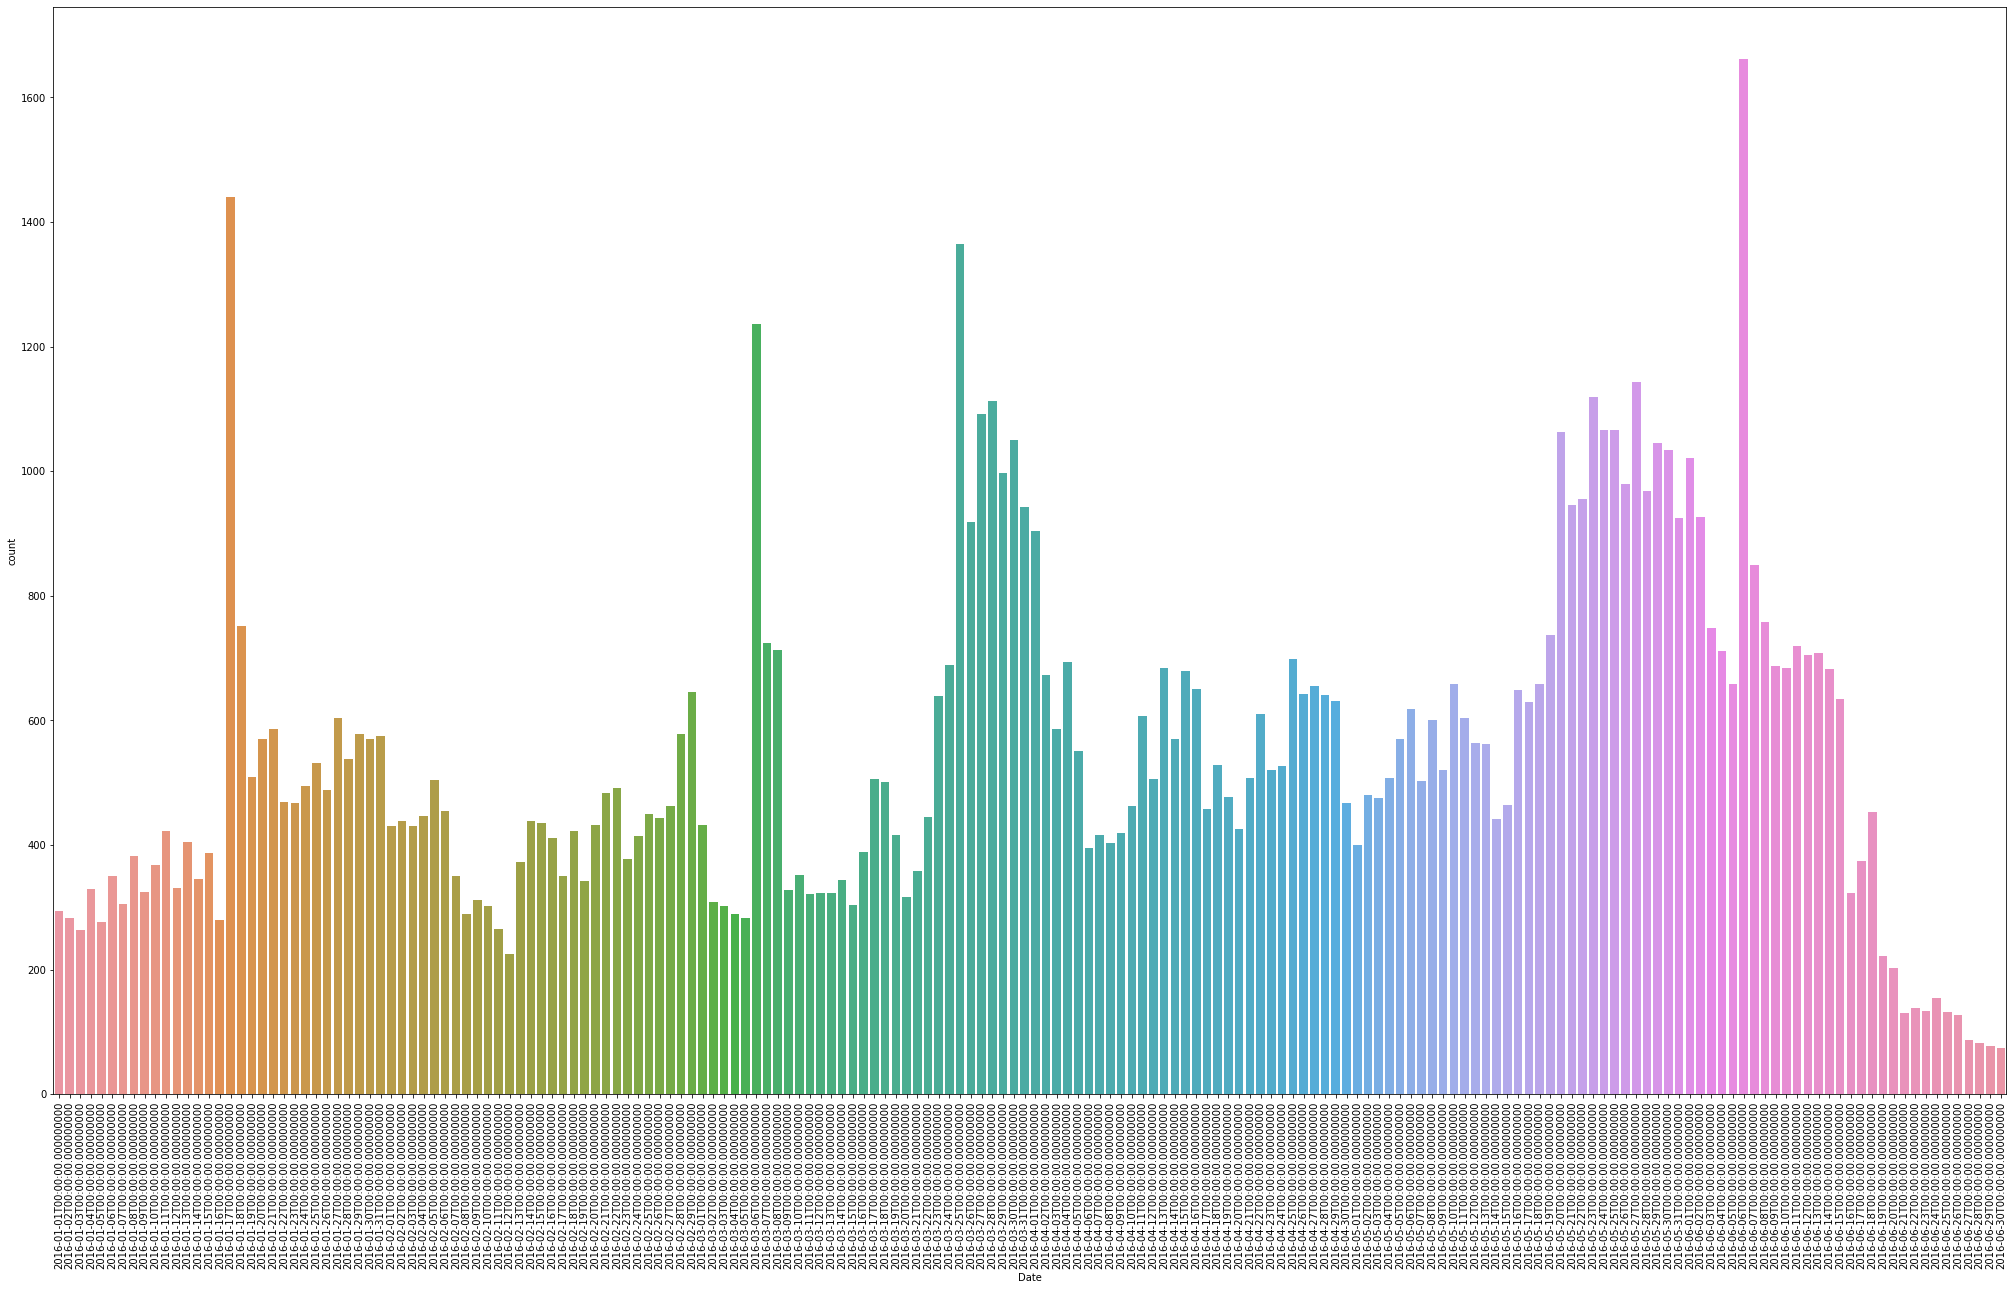

In [187]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_redeemed)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [188]:
on_off.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
2,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,36,5717,NaN,12349,20:5,2016-01-25,NaT,1,8.0


### Only Offline Users

In [189]:
df_offline = df_of_unique[df_of_unique['User_id'].isin(list(users_of - users_on_off))]

df_offline

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
2,35,3381,1807.0,300:30,0.0,2016-01-30,NaT,1
3,35,3381,9776.0,10:5,0.0,2016-01-29,NaT,1
4,35,3381,11951.0,200:20,0.0,2016-01-29,NaT,1
5,35,3381,11951.0,200:20,0.0,2016-01-30,NaT,1
9,110,4433,190.0,200:20,NaN,2016-01-31,NaT,1
...,...,...,...,...,...,...,...,...
1716955,7360845,1569,5054.0,200:30,NaN,2016-04-13,NaT,1
1716956,7360845,5341,11539.0,30:5,NaN,2016-01-28,2016-02-15,1
1716978,7360952,3403,13285.0,20:5,NaN,2016-05-24,NaT,1
1716980,7360966,3381,11951.0,200:20,NaN,2016-01-29,NaT,1


In [190]:
date_off_redeemed = df_offline[(df_offline["Date"].isna()==False) & (df_offline["Coupon_id"].isna()==False)]

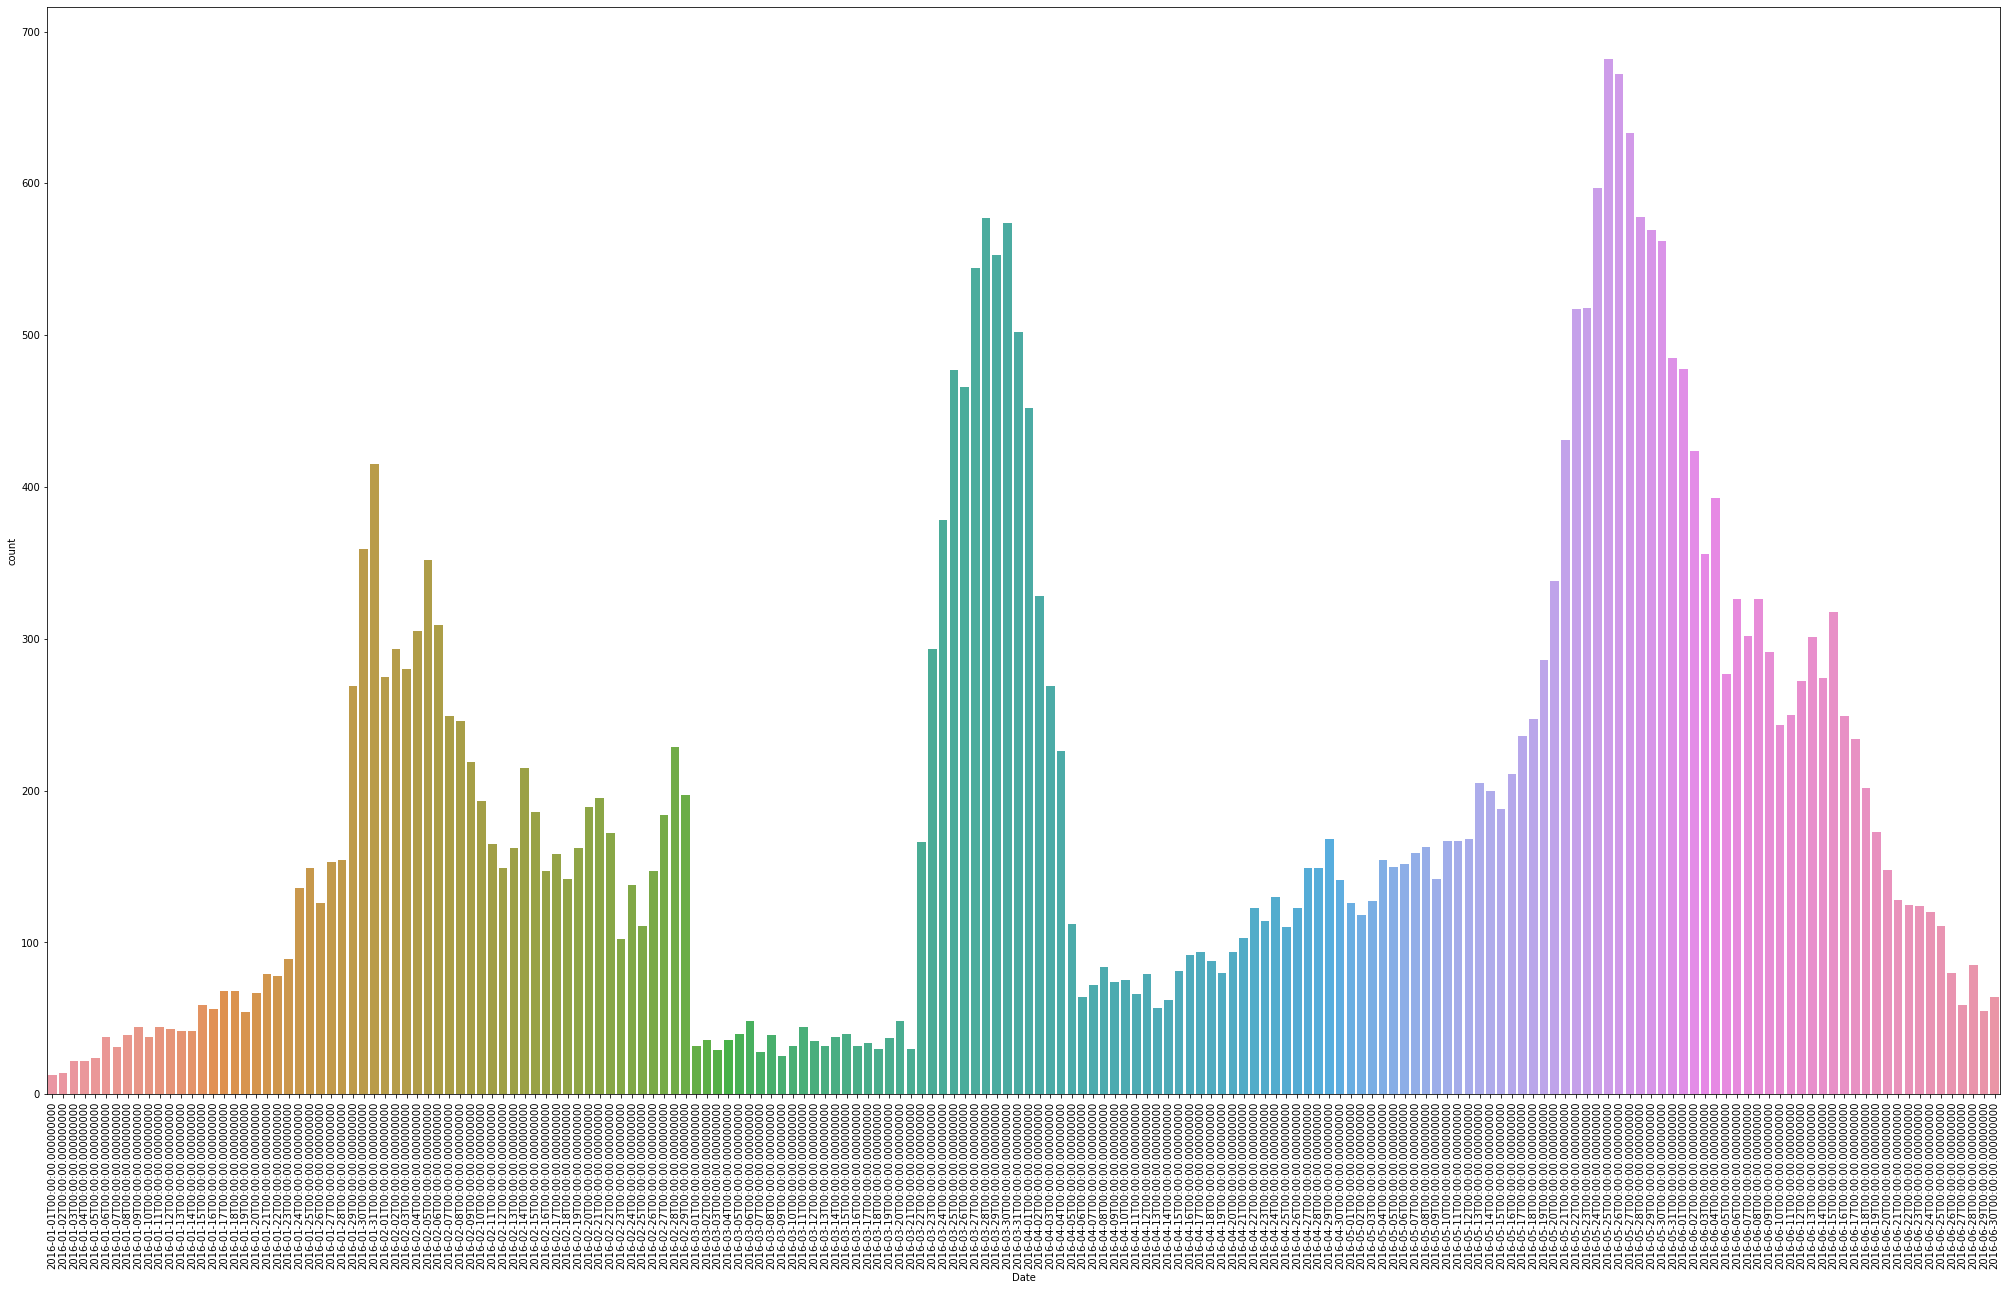

In [191]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_off_redeemed["Date"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [192]:
np.sort(df_offline["Count"].unique())

array([ 1,  2,  3,  4,  5,  6,  7, 12])

In [193]:
activity_offline = df_offline.groupby("User_id")["Count"].sum()
activity_offline

User_id
35         4
110        3
147        1
166        1
228        1
          ..
7360825    2
7360845    3
7360952    1
7360966    1
7361024    1
Name: Count, Length: 271990, dtype: int64

In [194]:
df_activity_offline = pd.DataFrame(activity_offline).reset_index()
df_activity_offline.columns = ['User_id', 'ActivityCount']
df_activity_offline["ActivityCount"].describe()

count    271990.000000
mean          3.058050
std           4.645573
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         137.000000
Name: ActivityCount, dtype: float64

In [195]:
# df_offline[df_offline["User_id"]==2949273].head(60)

### Only Online Users


In [196]:
df_online = df_on_unique[df_on_unique['User_id'].isin(list(users_on - users_on_off))]
date_redeemed_on = df_online[(df_online["Date"].isna()==False) & (df_online["Coupon_id"].isna()==False)]

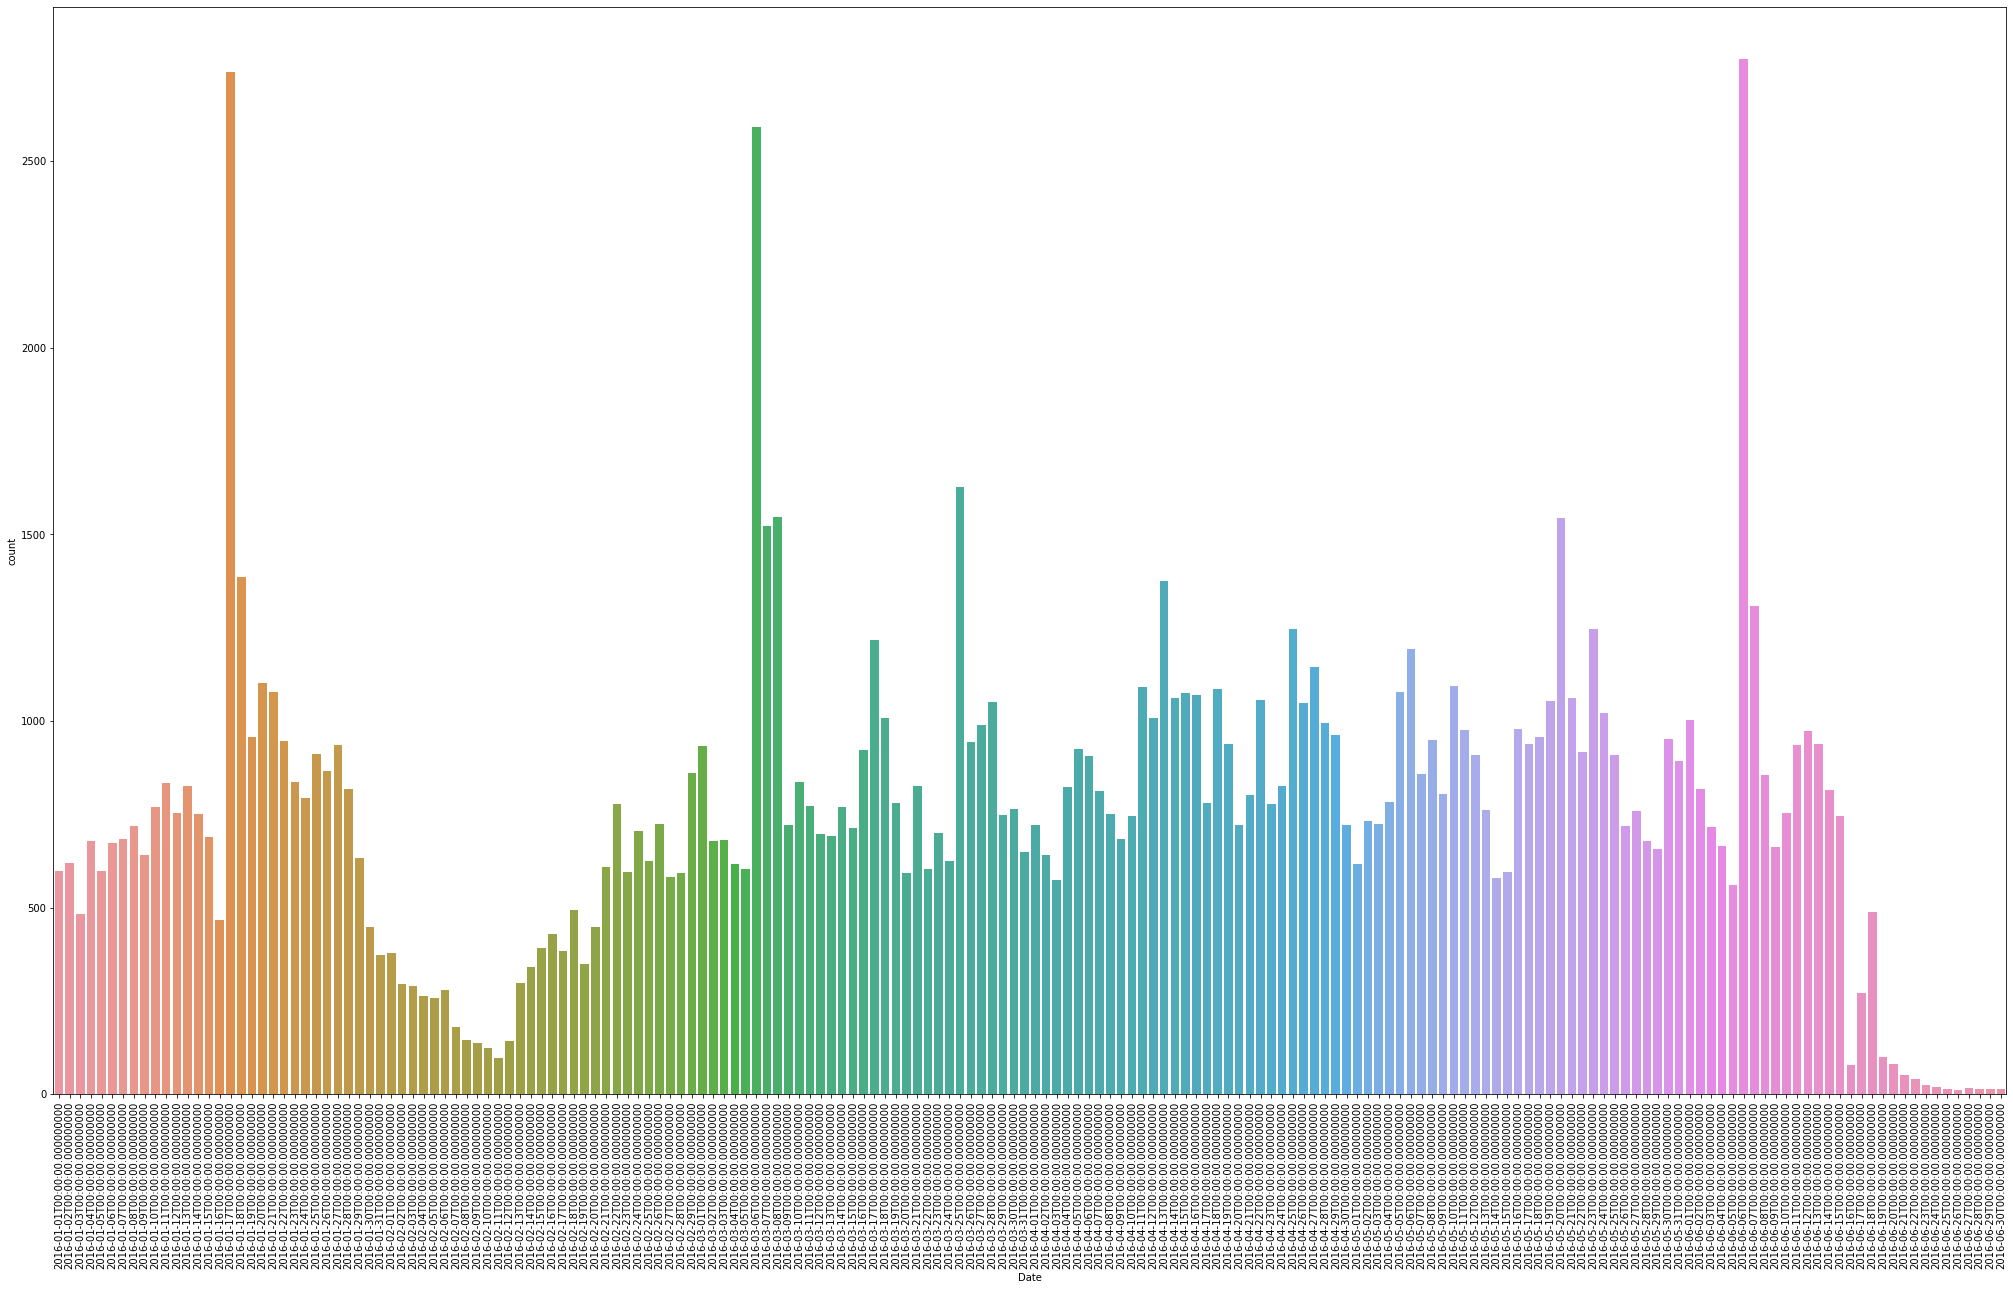

In [197]:
plt.figure(figsize=(35,20))
ax = sns.countplot(date_redeemed_on["Date"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [198]:
df_online_total = df_online.shape[0]
df_online_total

4557134

In [199]:
activity_online = df_online.groupby("User_id")["Count"].sum()
activity_online
#df_activity_online = df_online.groupby("User_id")["Count"].sum()

User_id
388           3
584           2
1147          2
1603          1
2723         34
           ... 
15499965    134
15499966     13
15499998      3
15499999    109
15500000      1
Name: Count, Length: 495410, dtype: int64

In [200]:
df_activity_online = pd.DataFrame(activity_online).reset_index()
df_activity_online.columns = ['User_id', 'ActivityCount']
df_activity_online

,User_id,ActivityCount
0,388,3
1,584,2
2,1147,2
3,1603,1
4,2723,34
...,...,...
495405,15499965,134
495406,15499966,13
495407,15499998,3
495408,15499999,109


In [201]:
df_activity_online[df_activity_online["ActivityCount"]==5786] 

,User_id,ActivityCount
368241,14015266,5786


In [202]:
# df_online[(df_online["User_id"]==14015266)].head(50)

#### User and User's merchant preference

In [203]:
#User and user's merchant preference
freq_visits = pd.DataFrame(df_of_unique.groupby(['User_id','Merchant_id']).size()).reset_index()
freq_visits.columns = ['User_id','Merchant_id','Visits']
freq_visits['Visits'].shape

(921146,)

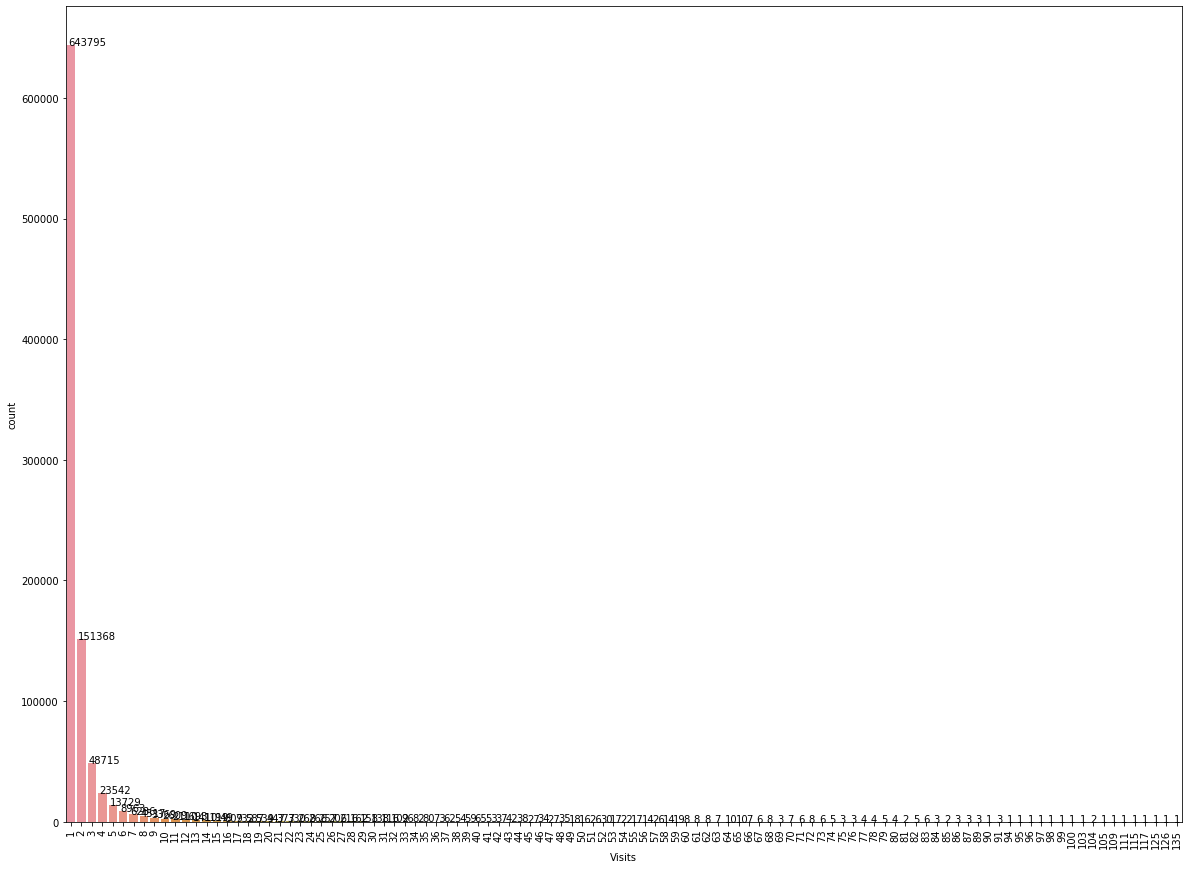

In [494]:
plt.figure(figsize=(20,15))
ax = sns.countplot(freq_visits['Visits'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
i = 4
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
#         i-=1
#         if i <0:
#             break
plt.show()

For offline:<br>
Around 69% of times the frequency of user-merchant pair is 1.<br>
For online:<br>
Around 79.4% of times the frequency of user-merchant pair is 1.<br>
So,in online as well as in offline, users don't prefer any certain set of merchants.

#### For any user-merchant pair, the distance should remain constant

In [205]:
user_merchant_distance = pd.DataFrame(df_of.groupby(['User_id','Merchant_id'])['Distance'].nunique()).reset_index()

In [206]:
user_merchant_distance['Distance'].unique()

array([1, 0])

Unique distance values for a user-merchant pair are 0 (for nan distance value) and 1.<br>
This shows for any user-merchant pair, the distance value remains constant.

#### Discount Rate should be constant for a particular coupon ids

In [207]:
# df_on.groupby(['Coupon_id'])['Discount_rate'].nunique().unique()

In [208]:
df_of.groupby(['Coupon_id'])['Discount_rate'].nunique().unique()

array([1])

For online and offline:<br>
For any coupon id, its discount remains constant.


#### Non Purchasers do not get enough coupons. (online)

In [209]:
user_action = df_online_actions.groupby(['User_id'])['Action_0','Action_1','Action_2'].sum()
user_action 

,Action_0,Action_1,Action_2
User_id,,,
4,0,1,1
36,1,0,0
64,2,1,0
144,1,0,0
165,0,1,0
...,...,...,...
15499965,126,7,1
15499966,12,1,0
15499998,3,0,0


In [210]:
purchaser = user_action[user_action['Action_1']!=0]
non_purchaser = user_action[user_action['Action_1']==0]
purchaser

,Action_0,Action_1,Action_2
User_id,,,
4,0,1,1
64,2,1,0
165,0,1,0
184,0,2,0
209,1,4,0
...,...,...,...
15499932,16,2,0
15499933,3,2,1
15499965,126,7,1


Total online users: 762,858 <br>
Purchaser(have atleast 1 buy action) : 54%<br>
Non Purchaser(no buy action) : 46%<br>
Coupon Distribtion:<br>
Total coupons distributed 655898 <br>
73% of the coupons distributed goes to purchasers and 27% goes to non purchasers

#### A user should redeem a coupon to the nearest store

In [324]:
offline_redeemed = df_of_unique[(df_of_unique['Date'].isna()==False) & (df_of_unique['Coupon_id'].isna()==False)]
len(offline_redeemed['Coupon_id'].unique())

6865

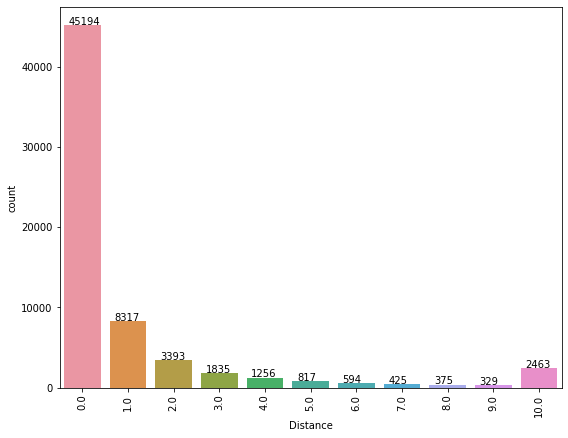

In [221]:
plt.figure(figsize=(9,7))
ax = sns.countplot(offline_redeemed['Distance'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

When a coupon is redeemed offline, 61% of the times it is redeemed at a store which is at 0 (less than 500m) distance

In [225]:
offline_redeemed[offline_redeemed['Distance'].isna()].shape

(8066, 8)

#### Discount and Redemption

In [380]:
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),2)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

For Offline:

In [239]:
len(df_of['Discount_rate'].unique())

46

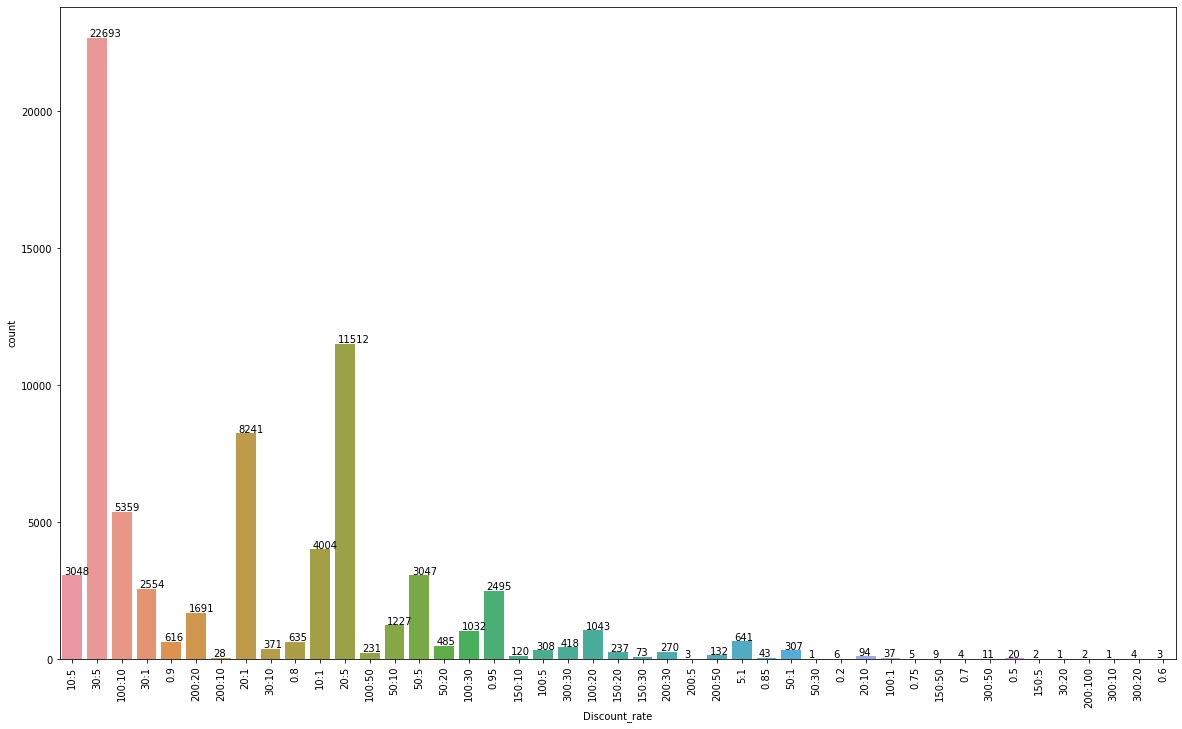

In [293]:
plt.figure(figsize=(20,12))
ax = sns.countplot(offline_redeemed['Discount_rate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [319]:
discount = df_of['Discount_rate'].value_counts()
of_discount = pd.DataFrame(discount).reset_index()
of_discount.columns = ['Discount_rate','Total_coupons']


0.25701758883186077

In [383]:
discount_red = offline_redeemed['Discount_rate'].value_counts()
of_discount_redeemed = pd.DataFrame(discount_red).reset_index()
of_discount_redeemed.columns = ['Discount_rate','Coupons_Redeemed']
of_discount_redeemed.head()

,Discount_rate,Coupons_Redeemed
0,30:5,22693
1,20:5,11512
2,20:1,8241
3,100:10,5359
4,10:1,4004


In [416]:
df_discount_of = of_discount.merge(of_discount_redeemed)
df_discount_of['Ratio'] = df_discount_of['Coupons_Redeemed']/df_discount_of['Total_coupons']
df_discount_of['Discount'] = df_discount_of['Discount_rate']
df_discount_of.head()

,Discount_rate,Total_coupons,Coupons_Redeemed,Ratio,Discount
0,30:5,270712,22693,0.083827,30:5
1,100:10,182554,5359,0.029356,100:10
2,200:20,111046,1691,0.015228,200:20
3,20:5,91013,11512,0.126487,20:5
4,20:1,51705,8241,0.159385,20:1


In [417]:
df_discount_of['Discount_rate'] = df_discount_of['Discount_rate'].map(convert_discount(list(of_discount_redeemed['Discount_rate'])))

In [418]:
df_discount_of[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_discount_of.Discount_rate.values.tolist(), index= df_discount_of.index)
df_discount_of.head()


,Discount_rate,Total_coupons,Coupons_Redeemed,Ratio,Discount,Original_price,Discounted_price,Rate
0,"[30, 5, 0.83]",270712,22693,0.083827,30:5,30,5,0.83
1,"[100, 10, 0.9]",182554,5359,0.029356,100:10,100,10,0.90
2,"[200, 20, 0.9]",111046,1691,0.015228,200:20,200,20,0.90
3,"[20, 5, 0.75]",91013,11512,0.126487,20:5,20,5,0.75
4,"[20, 1, 0.95]",51705,8241,0.159385,20:1,20,1,0.95


In [401]:
# plt.figure(figsize=(20,12))
# ax = sns.countplot(x = rate_offline['Rate'],data = rate_offline['Frequency'])
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
# for p in ax.patches:
#         ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
# plt.show()

In [277]:
df_of[df_of['User_id'] == 35]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
678050,35,3381,9776.0,10:5,0.0,20160129.0,NaN
678051,35,3381,1807.0,300:30,0.0,20160130.0,NaN
678052,35,3381,11951.0,200:20,0.0,20160129.0,NaN
678053,35,3381,11951.0,200:20,0.0,20160130.0,NaN


For Online:<br>
60% fixed discounts

In [302]:
online_redeemed = df_on_unique[(df_on_unique['Date'].isna()==False) & (df_on_unique['Coupon_id'].isna()==False)  & (df_on_unique['Coupon_id']!='fixed')]
online_redeemed.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
14,209,27710,1,100081876,150:10,2016-05-14,2016-05-14,1
61,387,14305,1,100032161,10:5,2016-05-16,2016-05-20,1
116,696,26705,1,100128459,30:20,2016-02-13,2016-02-13,1
196,944,47311,1,100225309,100:5,2016-05-26,2016-05-26,1
218,1202,18907,1,100102905,300:30,2016-02-25,2016-02-25,1


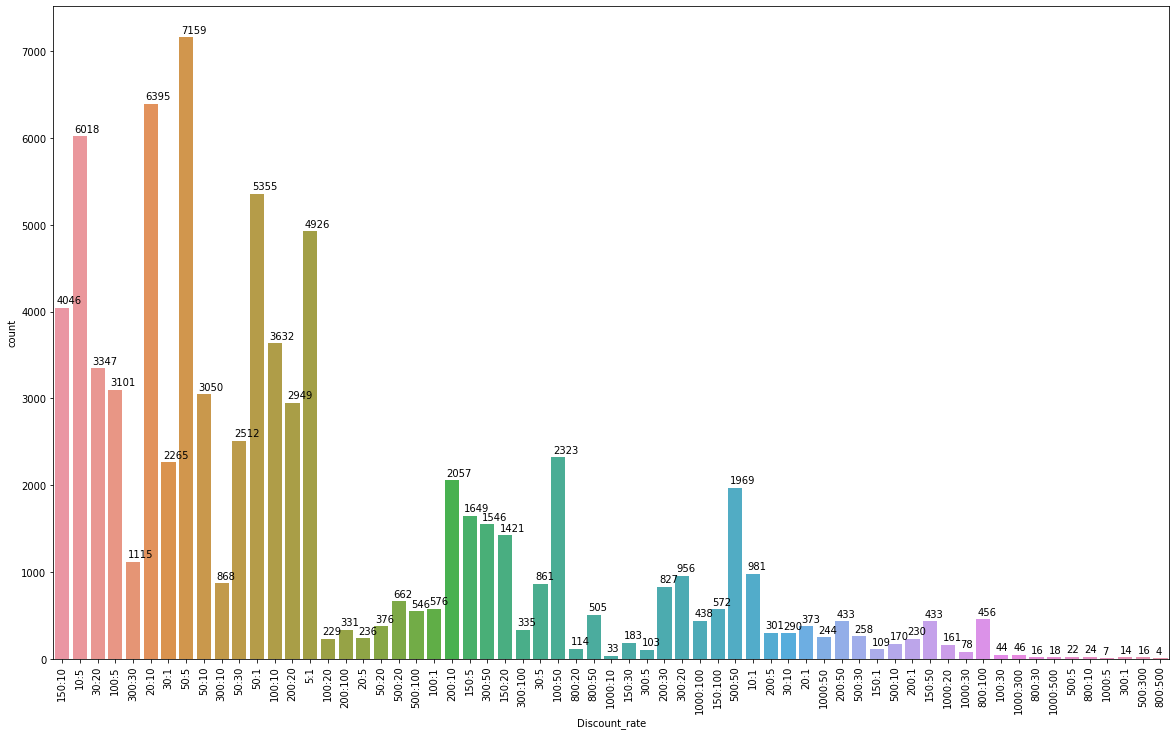

In [305]:
plt.figure(figsize=(20,12))
ax = sns.countplot(online_redeemed['Discount_rate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [309]:
type(df_on['Discount_rate'][0])

str

In [312]:
online_redeemed[online_redeemed['Discount_rate']=='200:1']

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count
28188,152624,50514,1,100209545,200:1,2016-03-25,2016-03-25,1
36874,199208,50514,1,100118221,200:1,2016-04-20,2016-04-20,1
44102,236043,39105,1,100221885,200:1,2016-03-03,2016-04-12,1
52768,288024,50514,1,100118221,200:1,2016-04-19,2016-04-19,1
58051,316756,50514,1,100137158,200:1,2016-03-06,2016-03-07,1
...,...,...,...,...,...,...,...,...
5729482,15384865,50514,1,100137158,200:1,2016-03-01,2016-03-01,2
5735335,15391531,50514,1,100194234,200:1,2016-06-05,2016-06-06,1
5754103,15413031,42808,1,100138416,200:1,2016-02-28,2016-03-16,1
5778110,15443532,50514,1,100209545,200:1,2016-03-24,2016-03-25,1


In [313]:
online_redeemed.shape

(80314, 8)

### Redemption Score of Merchants

In [461]:
merch_coupons_offline = df_of_unique[(df_of_unique['Coupon_id'].isna()==False)].groupby(['Merchant_id'])['Coupon_id','Date'].count()
merch_coupons_offline['Redemption'] = merch_coupons_offline['Date']/merch_coupons_offline['Coupon_id']
merch_coupons_offline[merch_coupons_offline['Redemption']==1]

,Coupon_id,Date,Redemption
Merchant_id,,,
56,1,1,1.0
183,2,2,1.0
216,1,1,1.0
221,4,4,1.0
277,1,1,1.0
...,...,...,...
8601,1,1,1.0
8695,1,1,1.0
8760,1,1,1.0


#### Filling Nan for Distance

In [455]:
df_of_unique['Distance'].fillna(df_of_unique['Distance'].mean(), inplace=True)
df_of_unique['Distance'] = df_of_unique.Distance.astype(int)

In [457]:
df_of_unique.tail(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count
1716986,7360967,3103,NaN,NaN,2,NaT,2016-01-20,1
1716987,7360967,6485,10323.0,20:5,1,2016-03-22,NaT,2
1716988,7361024,1433,8735.0,30:5,10,2016-02-11,NaT,1
1716989,7361032,2146,11173.0,100:10,2,2016-01-29,NaT,1
1716990,7361032,7019,3887.0,100:10,8,2016-01-29,NaT,1


In [458]:
offline_redeemed = df_of_unique[(df_of_unique['Date'].isna()==False) & (df_of_unique['Coupon_id'].isna()==False)]

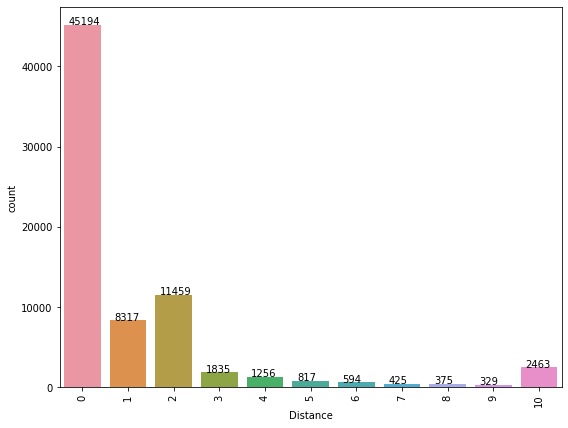

In [459]:
plt.figure(figsize=(9,7))
ax = sns.countplot(offline_redeemed['Distance'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

### Merchant and Average Distance

In [529]:
merch_dist = df_of_unique.groupby(['Merchant_id'])['Distance'].agg(['mean','count'])
merch_dist['mean'].describe()

count    8415.000000
mean        2.260195
std         2.091705
min         0.000000
25%         0.625000
50%         1.800000
75%         3.333333
max        10.000000
Name: mean, dtype: float64

### Merchant and Discounts

In [506]:
merch_discount = df_of_unique[df_of_unique['Coupon_id'].isna()==False]
merch_discount['Ratio_list'] = merch_discount['Discount_rate']
rates = list(merch_discount['Discount_rate'].unique())
merch_discount

/Users/mahimaarora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list
0,4,1433,8735.0,30:5,10,2016-02-14,NaT,1,30:5
1,4,1469,2902.0,0.95,10,2016-06-07,NaT,1,0.95
2,35,3381,1807.0,300:30,0,2016-01-30,NaT,1,300:30
3,35,3381,9776.0,10:5,0,2016-01-29,NaT,1,10:5
4,35,3381,11951.0,200:20,0,2016-01-29,NaT,1,200:20
...,...,...,...,...,...,...,...,...,...
1716984,7360967,3103,2375.0,30:1,2,2016-01-20,NaT,1,30:1
1716987,7360967,6485,10323.0,20:5,1,2016-03-22,NaT,2,20:5
1716988,7361024,1433,8735.0,30:5,10,2016-02-11,NaT,1,30:5
1716989,7361032,2146,11173.0,100:10,2,2016-01-29,NaT,1,100:10


In [507]:
merch_discount['Ratio_list'] = merch_discount['Ratio_list'].map(convert_discount(rates))
merch_discount

/Users/mahimaarora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list
0,4,1433,8735.0,30:5,10,2016-02-14,NaT,1,"[30, 5, 0.83]"
1,4,1469,2902.0,0.95,10,2016-06-07,NaT,1,"[100, 5, 0.95]"
2,35,3381,1807.0,300:30,0,2016-01-30,NaT,1,"[300, 30, 0.9]"
3,35,3381,9776.0,10:5,0,2016-01-29,NaT,1,"[10, 5, 0.5]"
4,35,3381,11951.0,200:20,0,2016-01-29,NaT,1,"[200, 20, 0.9]"
...,...,...,...,...,...,...,...,...,...
1716984,7360967,3103,2375.0,30:1,2,2016-01-20,NaT,1,"[30, 1, 0.97]"
1716987,7360967,6485,10323.0,20:5,1,2016-03-22,NaT,2,"[20, 5, 0.75]"
1716988,7361024,1433,8735.0,30:5,10,2016-02-11,NaT,1,"[30, 5, 0.83]"
1716989,7361032,2146,11173.0,100:10,2,2016-01-29,NaT,1,"[100, 10, 0.9]"


In [508]:
merch_discount[['Original_price','Discounted_price','Rate']] = pd.DataFrame(merch_discount.Ratio_list.values.tolist(), index= merch_discount.index)
merch_discount

/Users/mahimaarora/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list,Original_price,Discounted_price,Rate
0,4,1433,8735.0,30:5,10,2016-02-14,NaT,1,"[30, 5, 0.83]",30,5,0.83
1,4,1469,2902.0,0.95,10,2016-06-07,NaT,1,"[100, 5, 0.95]",100,5,0.95
2,35,3381,1807.0,300:30,0,2016-01-30,NaT,1,"[300, 30, 0.9]",300,30,0.90
3,35,3381,9776.0,10:5,0,2016-01-29,NaT,1,"[10, 5, 0.5]",10,5,0.50
4,35,3381,11951.0,200:20,0,2016-01-29,NaT,1,"[200, 20, 0.9]",200,20,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
1716984,7360967,3103,2375.0,30:1,2,2016-01-20,NaT,1,"[30, 1, 0.97]",30,1,0.97
1716987,7360967,6485,10323.0,20:5,1,2016-03-22,NaT,2,"[20, 5, 0.75]",20,5,0.75
1716988,7361024,1433,8735.0,30:5,10,2016-02-11,NaT,1,"[30, 5, 0.83]",30,5,0.83
1716989,7361032,2146,11173.0,100:10,2,2016-01-29,NaT,1,"[100, 10, 0.9]",100,10,0.90


In [510]:
merch_discount.sort_values(by = ['Merchant_id'])

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list,Original_price,Discounted_price,Rate
1542839,6621282,2,7354.0,100:20,2,2016-05-17,NaT,1,"[100, 20, 0.8]",100,20,0.80
385637,1657650,2,7354.0,100:20,10,2016-05-18,NaT,1,"[100, 20, 0.8]",100,20,0.80
251273,1091900,2,7354.0,100:20,10,2016-05-19,NaT,1,"[100, 20, 0.8]",100,20,0.80
492408,2121631,2,7354.0,100:20,10,2016-05-20,NaT,1,"[100, 20, 0.8]",100,20,0.80
880686,3789187,2,7354.0,100:20,10,2016-05-16,NaT,1,"[100, 20, 0.8]",100,20,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...
57220,250422,8856,83.0,10:1,0,2016-06-06,NaT,1,"[10, 1, 0.9]",10,1,0.90
1716923,7360651,8856,83.0,10:1,0,2016-06-06,NaT,1,"[10, 1, 0.9]",10,1,0.90
1675872,7186324,8856,5495.0,20:1,1,2016-06-14,NaT,1,"[20, 1, 0.95]",20,1,0.95
234176,1016869,8856,5495.0,20:1,0,2016-06-15,NaT,1,"[20, 1, 0.95]",20,1,0.95


In [517]:
merch_discount.groupby(['Merchant_id'])['Rate'].mean()

Merchant_id
2       0.800000
3       0.670000
4       0.830000
5       0.750000
8       0.500000
          ...   
8849    0.950000
8850    0.950000
8852    0.950000
8854    0.950000
8856    0.943243
Name: Rate, Length: 5599, dtype: float64

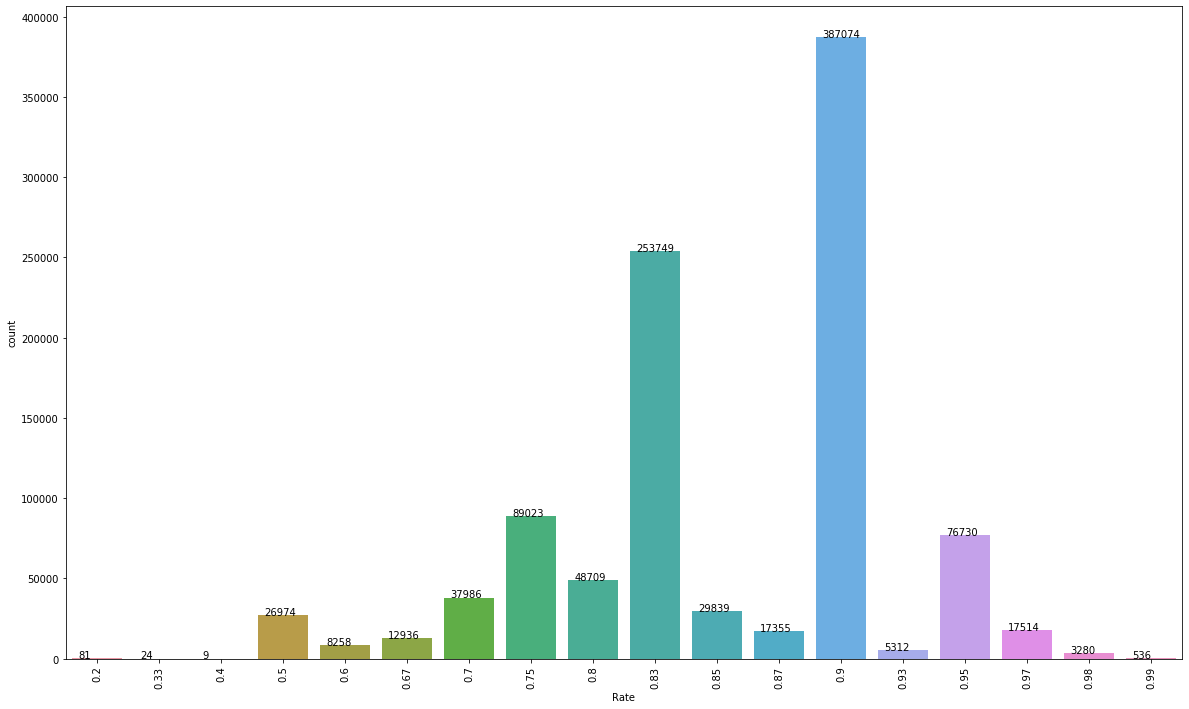

In [520]:
plt.figure(figsize=(20,12))
ax = sns.countplot(merch_discount['Rate'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [525]:
merch_discount[merch_discount['Rate']>0.84]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Ratio_list,Original_price,Discounted_price,Rate
1,4,1469,2902.0,0.95,10,2016-06-07,NaT,1,"[100, 5, 0.95]",100,5,0.95
2,35,3381,1807.0,300:30,0,2016-01-30,NaT,1,"[300, 30, 0.9]",300,30,0.90
4,35,3381,11951.0,200:20,0,2016-01-29,NaT,1,"[200, 20, 0.9]",200,20,0.90
5,35,3381,11951.0,200:20,0,2016-01-30,NaT,1,"[200, 20, 0.9]",200,20,0.90
8,64,2146,11173.0,100:10,2,2016-01-29,NaT,1,"[100, 10, 0.9]",100,10,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
1716980,7360966,3381,11951.0,200:20,2,2016-01-29,NaT,1,"[200, 20, 0.9]",200,20,0.90
1716983,7360967,3103,2375.0,30:1,2,2016-01-10,NaT,1,"[30, 1, 0.97]",30,1,0.97
1716984,7360967,3103,2375.0,30:1,2,2016-01-20,NaT,1,"[30, 1, 0.97]",30,1,0.97
1716989,7361032,2146,11173.0,100:10,2,2016-01-29,NaT,1,"[100, 10, 0.9]",100,10,0.90


In [549]:
rate_ratio = merch_discount.groupby(['Rate'])['Coupon_id','Date'].count()
rate_ratio['Ratio'] = rate_ratio['Date']/rate_ratio['Coupon_id']
rate_ratio

,Coupon_id,Date,Ratio
Rate,,,
0.20,81,6,0.074074
0.33,24,1,0.041667
0.40,9,1,0.111111
0.50,26974,3395,0.125862
0.60,8258,488,0.059094
0.67,12936,380,0.029375
0.70,37986,1036,0.027273
0.75,89023,11649,0.130854
0.80,48709,3619,0.074298


#### User and coupon redemption

#### Online

In [564]:
user_getandredeem_on = df_on.groupby(['User_id','Coupon_id'])['Discount_rate','Date'].count()
user_getandredeem_on['RedeemFlag'] = (user_getandredeem_on['Date']>0) & (user_getandredeem_on['Date']<user_getandredeem_on['Discount_rate'])
user_getandredeem_on[user_getandredeem_on['RedeemFlag']==True].head()

,,Discount_rate,Date,RedeemFlag
User_id,Coupon_id,,,
5387,100124136,2,1,True
9112,100151406,2,1,True
11663,100224586,3,1,True
20198,100053149,2,1,True
21727,100190995,2,1,True


In [559]:
df_on[(df_on['User_id']==5387) & (df_on['Coupon_id']=='100124136')]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
Index,,,,,,,
10122198,5387,14809,2,100124136,100:10,20160410.0,NaN
10122203,5387,14809,1,100124136,100:10,20160410.0,20160414.0


In [561]:
df_on[]

0.01601058095886117

#### Offline

In [573]:
user_getandredeem_of = df_of.groupby(['User_id','Coupon_id'])['Discount_rate','Date'].count()
user_getandredeem_of['RedeemFlag'] = (user_getandredeem_of['Date']>0) & (user_getandredeem_of['Date']<user_getandredeem_of['Discount_rate'])
user_getandredeem_of[user_getandredeem_of['RedeemFlag']==True].head(20)


Discount_rate  Date  RedeemFlag
User_id Coupon_id                                 
687     14031.0                2     1        True
696     3726.0                 2     1        True
947     12414.0                2     1        True
1318    2810.0                 2     1        True
        9614.0                 2     1        True
2266    4727.0                 6     3        True
5551    2062.0                 2     1        True
        6615.0                 2     1        True
5569    5582.0                 3     2        True
8107    1268.0                 2     1        True
8397    8556.0                 6     2        True
8516    5582.0                 2     1        True
8722    11539.0                2     1        True
8833    11942.0                4     1        True
9690    7224.0                 2     1        True
10017   4727.0                 2     1        True
10098   4727.0                 2     1        True
10473   4366.0                 5     3        True
10969   11244.0                2     1        True
11170   7851.0                 3     2        True

In [574]:
df_of[(df_of['User_id']==2266) & (df_of['Coupon_id']==4727)]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
96264,2266,7422,4727.0,0.8,6.0,20160304.0,20160304.0
96265,2266,7422,4727.0,0.8,6.0,20160528.0,20160528.0
96267,2266,7422,4727.0,0.8,6.0,20160305.0,NaN
96268,2266,7422,4727.0,0.8,6.0,20160612.0,NaN
96269,2266,7422,4727.0,0.8,6.0,20160518.0,NaN
96270,2266,7422,4727.0,0.8,6.0,20160312.0,20160312.0
